# Deliverable 1 - Categorical Classifier

## Import

In [1]:
# Disable Tensorflow's warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pathlib
from typing import Any,Union   

2022-10-07 10:54:38.366370: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Global Variables

In [3]:
BATCH_SIZE:int = 64
IMG_HEIGHT:int = 227
IMG_WIDTH:int = 227
EPOCHS = 10

## Load Thomas's Dataset

In [4]:
# Train
train_data = tf.keras.utils.image_dataset_from_directory('data_cat_thomas/train',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Validation
val_data = tf.keras.utils.image_dataset_from_directory('data_cat_thomas/val',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Evaluation
test_data = tf.keras.utils.image_dataset_from_directory('data_cat_thomas/test',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Get class names form dataset 
class_names = train_data.class_names

Found 32439 files belonging to 5 classes.
Found 4057 files belonging to 5 classes.
Found 4064 files belonging to 5 classes.


In [5]:
# Load datasets in cache to optimize training time
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Model

In [6]:
with tf.device('/GPU:0'):
    model = tf.keras.Sequential([
        # Rescaling (rescale pixel values between 0 and 1)
        tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Convolution Layers (feature extraction)
        tf.keras.layers.Conv2D(64, 3, 1, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=None, padding="valid"),

        tf.keras.layers.Conv2D(128, 3, 1, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=None, padding="valid"),

        tf.keras.layers.Conv2D(256, 3, 1, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=None, padding="valid"),

        tf.keras.layers.Conv2D(512, 3, 1, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=None, padding="valid"),

        tf.keras.layers.Conv2D(512, 3, 1, activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=None, padding="valid"),

        # Deep Neural Network Layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),

        # Output Layer (Categorical model: 5 neurones and softmax activation)
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adamax',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

## Train

In [7]:
# Checkpoint callback to save the best weights during training
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/tmp/checkpoint/cat',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [8]:
# Train the model
with tf.device('/GPU:0'):
    history:tf.keras.callbacks.History = model.fit(
        train_data,
        validation_data=val_data,
        epochs=EPOCHS,
        # Call to the checkpoint callback
        callbacks=model_checkpoint_callback
    )

Epoch 1/10
253/507 [=============>................] - ETA: 1:00 - loss: 0.8925 - accuracy: 0.6074

Corrupt JPEG data: 419 extraneous bytes before marker 0xd9


507/507 [==============================] - 145s 271ms/step - loss: 0.7181 - accuracy: 0.6907 - val_loss: 0.4332 - val_accuracy: 0.8284
Epoch 2/10
507/507 [==============================] - 128s 252ms/step - loss: 0.4144 - accuracy: 0.8316 - val_loss: 0.3210 - val_accuracy: 0.8657
Epoch 3/10
507/507 [==============================] - 127s 251ms/step - loss: 0.3165 - accuracy: 0.8757 - val_loss: 0.2950 - val_accuracy: 0.8775
Epoch 4/10
507/507 [==============================] - 128s 252ms/step - loss: 0.2745 - accuracy: 0.8920 - val_loss: 0.2732 - val_accuracy: 0.8952
Epoch 5/10
507/507 [==============================] - 128s 252ms/step - loss: 0.2455 - accuracy: 0.9041 - val_loss: 0.2271 - val_accuracy: 0.9177
Epoch 6/10
507/507 [==============================] - 128s 252ms/step - loss: 0.2128 - accuracy: 0.9172 - val_loss: 0.1974 - val_accuracy: 0.9298
Epoch 7/10
507/507 [==============================] - 126s 248ms/step - loss: 0.1847 - accuracy: 0.9283 - val_loss: 0.2189 - val_accura

## Graphs of the evolution of accuracy and loss 

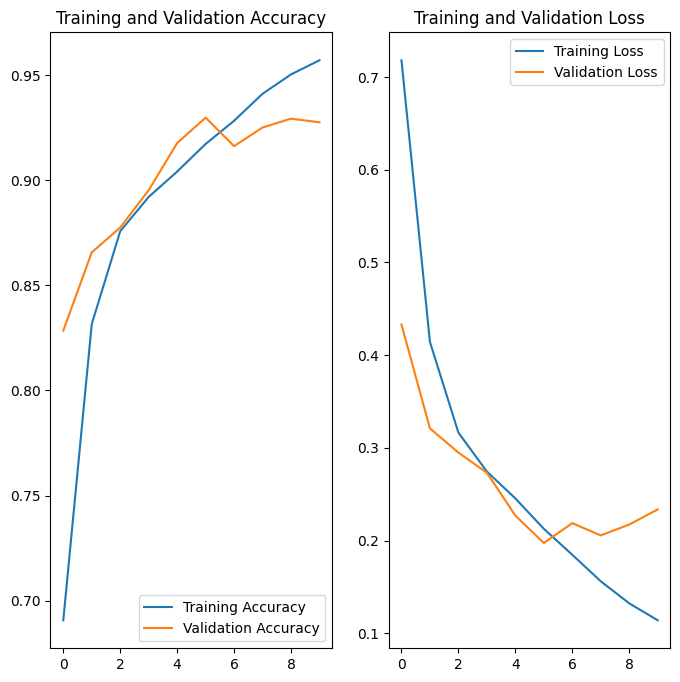

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evalutaion

In [10]:
# Load best weights (checkpoint)
model.load_weights('/tmp/checkpoint/cat')

In [11]:
# Evaluate the model with test dataset
print("Evaluate on test data")
results = model.evaluate(test_data, batch_size=64)
print("test loss, test acc:", results)

Evaluate on test data
64/64 [==============================] - 10s 146ms/step - loss: 0.2091 - accuracy: 0.9218
test loss, test acc: [0.20906007289886475, 0.9217519760131836]


## Save

In [12]:
import datetime
import pandas as pd

date:datetime = datetime.datetime.now().strftime("%m.%d.%Y_%H:%M:%S")
model_dir:str = f"models/cat_{date}_{results[1]:.2f}%"
model.save(model_dir)
f = open(f"{model_dir}/model_summary.txt", "a")
model.summary(print_fn=lambda x: f.write(x + '\n'))
f.close()

f = open(f"{model_dir}/model_history.csv", "a")
f.write(pd.DataFrame.from_dict(history.history).to_csv(index=False))
f.close()

INFO:tensorflow:Assets written to: models/cat_10.07.2022_11:16:30_0.92%/assets


INFO:tensorflow:Assets written to: models/cat_10.07.2022_11:16:30_0.92%/assets
